# Data pre-processing

Se utilizó el dataset de "Datos de cinemática de movimiento" en [Kaggle](https://www.kaggle.com/datasets/yasserh/kinematics-motion-data?resource=download)

Es del interes de aplicaciones deportivas el identificar no solo la cantidad de pasos que una persona da durante el día, sino el tipo de ejercicio que está haciendo, en este caso, poder identificar si una persona está **corriendo** o **caminando**.

Los datos recolectados son de dispositivos iPhone 5c en intervalos de 10 segundos, donde se etiquetan a los datos como:


*   0: Caminando
*   1: Corriendo

Cada una de las filas tiene datos de giroscopio y aceleración, con los cuales se tiene una aplicación ad hoc para un modelo de clasificación. Se clasificará por 3 modelos para ver qué conclusiones se obtienen de cada uno:


1.   Modelo de Boosting (LGBM): Uno de los métodos de clasificación por ensamble de "weak learners" más usados en el mercado tiene en una gran eficacia y exactitud (accuracy).
2.   K-Neighbors: Es un modelo no paramétrico, en caso de que los datos no tengan una relación facil de distinguir, este podría tener mejores resultados 
3.   Regresión Logística: Puede ser que nuestros datos tengan una relación que los permita biseccionar a través de dos regiones en el espacio de variables, y en dado caso, un modelo barato como lo es la regresión logística podría resultar suficientemente adecuado para realizar esta clasificación.





In [ ]:
# Connecting to google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# General

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Classifiers

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb


# Train - Test split & Cross Validation

from sklearn.model_selection import train_test_split, KFold, cross_validate, StratifiedKFold

# Performance metics

from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# For normalization

from sklearn import preprocessing


In [ ]:
kinematics = pd.read_csv("drive/My Drive/Diplomado IA/Proyecto/Kinematics_Data.csv")

In [ ]:
kinematics.head()

,date,time,username,wrist,activity,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z
0,2017-6-30,13:51:15:847724020,viktor,0,0,0.2650,-0.7814,-0.0076,-0.0590,0.0325,-2.9296
1,2017-6-30,13:51:16:246945023,viktor,0,0,0.6722,-1.1233,-0.2344,-0.1757,0.0208,0.1269
2,2017-6-30,13:51:16:446233987,viktor,0,0,0.4399,-1.4817,0.0722,-0.9105,0.1063,-2.4367
3,2017-6-30,13:51:16:646117985,viktor,0,0,0.3031,-0.8125,0.0888,0.1199,-0.4099,-2.9336
4,2017-6-30,13:51:16:846738994,viktor,0,0,0.4814,-0.9312,0.0359,0.0527,0.4379,2.4922


In [ ]:
# Creando el dataset con dummies

columns = ['activity_1','acceleration_x', 'acceleration_y', 'acceleration_z',
           'gyro_x', 'gyro_y', 'gyro_z']

kinematics_dummies = (pd.get_dummies(kinematics,
                                columns = ['activity'], # Variable objetivo dummy
                                drop_first = [True])
                  .loc[:,columns] # Selects only the columns of interest
                  )

kinematics_dummies.head(5)

,activity_1,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z
0,0,0.2650,-0.7814,-0.0076,-0.0590,0.0325,-2.9296
1,0,0.6722,-1.1233,-0.2344,-0.1757,0.0208,0.1269
2,0,0.4399,-1.4817,0.0722,-0.9105,0.1063,-2.4367
3,0,0.3031,-0.8125,0.0888,0.1199,-0.4099,-2.9336
4,0,0.4814,-0.9312,0.0359,0.0527,0.4379,2.4922


In [ ]:
columns.remove('activity_1')

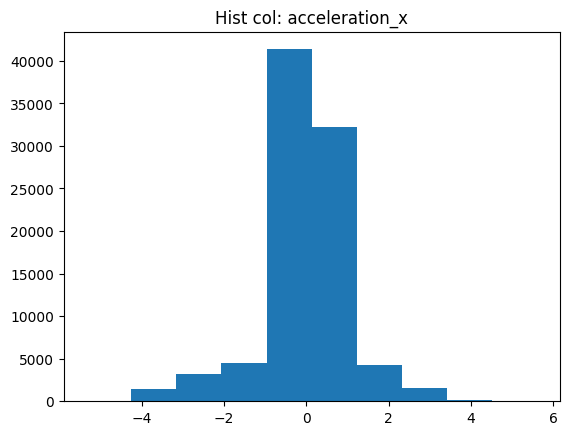

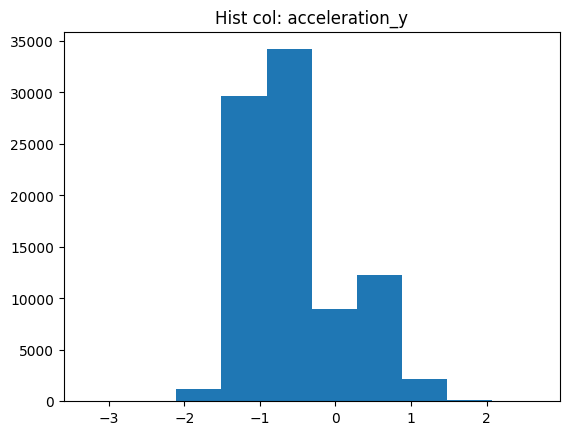

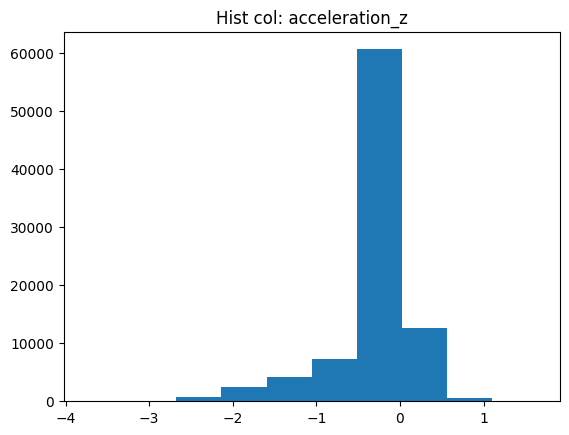

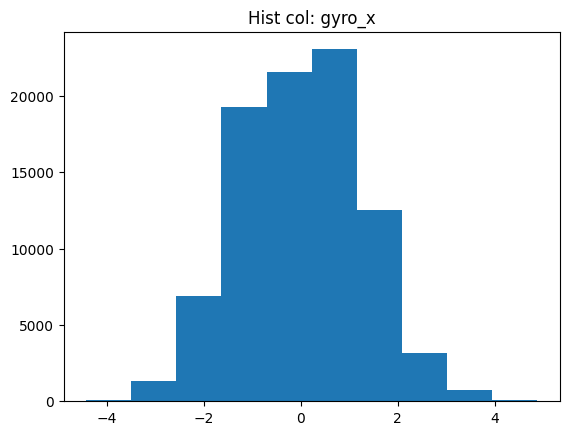

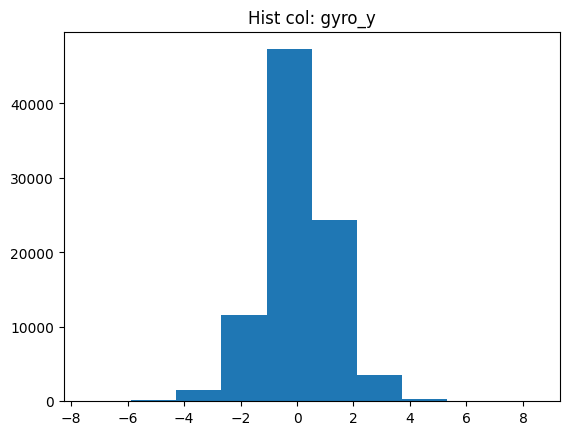

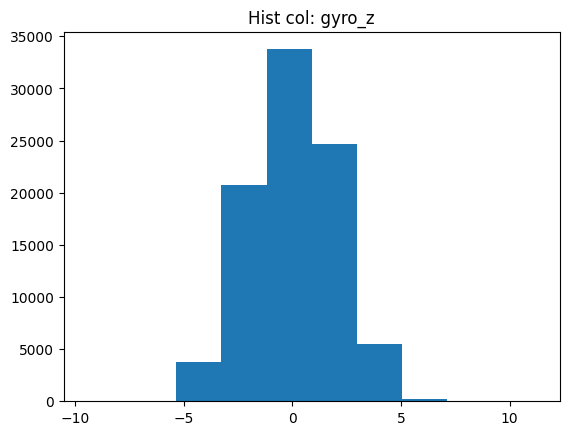

In [ ]:
for col in columns:
  plt.title("Hist col: "+ col)
  plt.hist(kinematics_dummies[col])
  plt.show()

In [ ]:
#normal_data = preprocessing.normalize(kinematics_dummies, axis=0)

In [ ]:
#kinematics_dummies = pd.DataFrame(normal_data, columns=kinematics_dummies.columns)

In [ ]:
#kinematics_dummies

In [ ]:
X = kinematics_dummies.copy().drop(columns=['activity_1']).values
y = kinematics_dummies.copy()['activity_1'].values

In [ ]:
X = preprocessing.normalize(X)

In [ ]:
# Evaluando la razón de datos

kinematics_dummies['activity_1'].value_counts()

1    44365
0    44223
Name: activity_1, dtype: int64

In [ ]:
# No hay undersampling de la clase positiva
print('balance ratio: ', round(y.sum()/(len(y) - y.sum()), 4))

balance ratio:  1.0032


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    stratify=y,
                                                    random_state=1)

# Creating the models

In [ ]:
# Stratified Cross Validation instance

skf = StratifiedKFold(n_splits=10, 
                      shuffle=True, 
                      random_state=1)

We are going to use Bayesin hyperparameter optimization, since Grid Search is limited to the range of values that can be exammined.

https://www.kaggle.com/code/prashant111/xgboost-k-fold-cv-feature-importance?scriptVersionId=48823316&cellId=62

In [ ]:
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 6.0 MB/s eta 0:00:00


In [ ]:
from skopt import BayesSearchCV

We need a range of values to analyze the posible hyperparameters for each of the classification algorithms

The hyperparameter optimization has to be done before the trainning, we can test the values before and after the hyperparameter optimization to compare the performance of the models before and after the process

De la [documentación](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html#for-better-accuracy) de LightGBM: 

For Better Accuracy:

*    Use large `max_bin` (may be slower)

*    Use small `learning_rate` with large `num_iterations`

*    Use large `num_leaves` (may cause over-fitting)

*    Use bigger training data



### LGBM

In [ ]:
# hyperparameter space, we will set the hyperparameters to avoid better accuracy
# Performance parameters

param_grid_lgbm = {
    'max_bin': (200, 300),
    'num_leaves': (2,50),
    'learning_rate': (0.0001, 0.1),
    'num_iterations': (100, 300),
}

In [ ]:
lgbmc = lgb.LGBMClassifier()

In [ ]:
clf_1 =  cross_validate(
    lgbmc,
    X_train, 
    y_train,
    scoring='recall',
    return_train_score=True,
    cv=skf,
)

In [ ]:
clf_1.values()

dict_values([array([3.98592782, 0.59256172, 0.67950892, 0.61331058, 0.58194947,
       0.60926938, 0.62678289, 0.60247087, 0.56887031, 0.56677508]), array([0.03501439, 0.03411007, 0.03452444, 0.03390002, 0.03633094,
       0.03463197, 0.03602171, 0.0337832 , 0.04952002, 0.03494573]), array([0.98083967, 0.98760214, 0.98872922, 0.98196675, 0.98281206,
       0.9833756 , 0.98534799, 0.98534799, 0.98309859, 0.98140845]), array([0.98995085, 0.98988824, 0.98960649, 0.98988824, 0.98973171,
       0.98938735, 0.98960649, 0.98982563, 0.9902323 , 0.99045144])])

In [ ]:
print(clf_1['train_score'].mean())
print(clf_1['test_score'].mean())

0.9898568721902741
0.9840528456736475


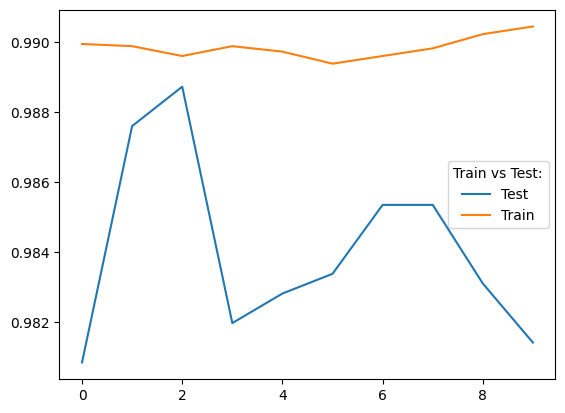

In [ ]:
plt.plot(range(10), clf_1['test_score'], label='Test')
plt.plot(range(10), clf_1['train_score'], label='Train')
plt.legend(title='Train vs Test:')
plt.show()

In [ ]:
lgbmc.fit(X_train, y_train)

LGBMClassifier()

In [ ]:
# predict the results
y_pred=lgbmc.predict(X_test)

In [ ]:
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

0.9892764420363472
0.9917317929550346
0.9868139298996957
0.9892667495198283


Ahora optimizando con hiperparámetros

In [ ]:
# set up the search
search = BayesSearchCV(estimator=lgbmc,
                       search_spaces=param_grid_lgbm,
                       #scoring='roc_auc',
                       cv=3,
                       n_iter=30,
                       random_state=10,
                       n_jobs=-1,
                       refit=True)

In [ ]:
search.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


BayesSearchCV(cv=3, estimator=LGBMClassifier(), n_iter=30, n_jobs=-1,
              random_state=10,
              search_spaces={'learning_rate': (0.0001, 0.1),
                             'max_bin': (200, 300),
                             'num_iterations': (100, 300),
                             'num_leaves': (2, 50)})

In [ ]:
search.best_params_

OrderedDict([('learning_rate', 0.1),
             ('max_bin', 278),
             ('num_iterations', 300),
             ('num_leaves', 46)])

In [ ]:
search.best_score_

0.9882602016865208

In [ ]:
# we also find the data for all models evaluated

results = pd.DataFrame(search.cv_results_)

print(results.shape)

results.head(5)

(30, 15)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_bin,param_num_iterations,param_num_leaves,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,2.850812,0.263066,0.486880,0.139831,0.004947,223,210,32,"{'learning_rate': 0.004946861294959385, 'max_b...",0.975110,0.973839,0.977522,0.975490,0.001527,26
1,5.034417,2.417247,0.718981,0.196630,0.09915,208,266,31,"{'learning_rate': 0.09915001550434563, 'max_bi...",0.987682,0.987597,0.988782,0.988020,0.000540,4
2,0.772606,0.157110,0.228705,0.036521,0.072118,227,124,19,"{'learning_rate': 0.07211760378559341, 'max_bi...",0.985396,0.985353,0.986412,0.985720,0.000489,23
3,0.888260,0.149642,0.253385,0.031197,0.086225,253,119,37,"{'learning_rate': 0.08622453224482902, 'max_bi...",0.987343,0.986539,0.988232,0.987371,0.000692,14
4,1.173839,0.231249,0.407461,0.020534,0.099835,242,216,21,"{'learning_rate': 0.09983522124557993, 'max_bi...",0.988021,0.986750,0.988782,0.987851,0.000838,9


Text(0.5, 0, 'Hyperparameter combinations')

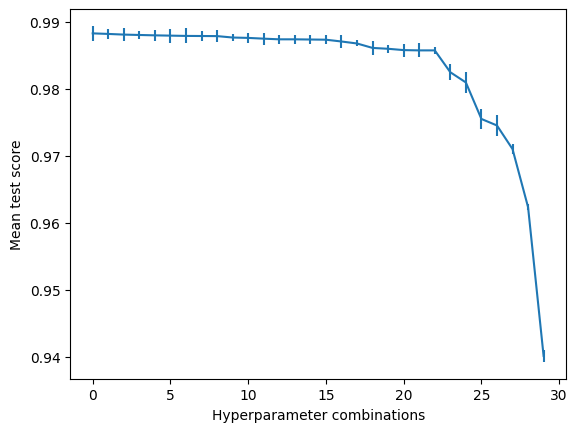

In [ ]:
# we can order the different models based on their performance
results.sort_values(by='mean_test_score', ascending=False, inplace=True)

results.reset_index(drop=True, inplace=True)

# plot model performance and error

results['mean_test_score'].plot(yerr=[results['std_test_score'], results['std_test_score']], subplots=True)

plt.ylabel('Mean test score')
plt.xlabel('Hyperparameter combinations')

In [ ]:
# predict the results
y_pred=search.predict(X_test)

In [ ]:
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

0.9902923580539564
0.9927511609468797
0.9878282429843345
0.9902835837758446


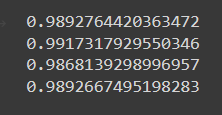

## K-Neighbors

Los hiperparámetros para el clasificador de K-Neighbors enlista sus hiper parámetros en la [documentación](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

In [ ]:
# hyperparameter space, we will set the hyperparameters to avoid better accuracy

param_grid_knn = {
    'n_neighbors': (4, 20), # default = 5
    'weights': ['uniform', 'distance'], # default = 'uniform'
    'leaf_size': (10, 40), # default = 30
}

In [ ]:
knn = KNeighborsClassifier(n_jobs=-1)

In [ ]:
clf_2 =  cross_validate(
    knn,
    X_train, 
    y_train,
    scoring='recall',
    return_train_score=True,
    cv=skf,
)

In [ ]:
print(clf_2['train_score'].mean())
print(clf_2['test_score'].mean())

0.9777226795993622
0.9705287027887245


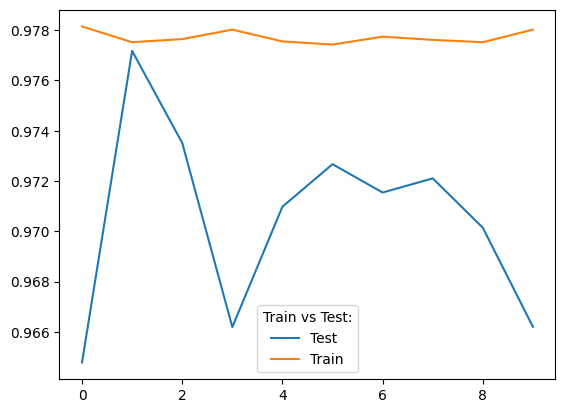

In [ ]:
plt.plot(range(10), clf_2['test_score'], label='Test')
plt.plot(range(10), clf_2['train_score'], label='Train')
plt.legend(title='Train vs Test:')
plt.show()

In [ ]:
knn.fit(X_train, y_train)

KNeighborsClassifier(n_jobs=-1)

In [ ]:
y_pred=lgbmc.predict(X_test)

In [ ]:
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

0.9892764420363472
0.9917317929550346
0.9868139298996957
0.9892667495198283


Ahora optimizando con hiperparámetros

In [ ]:
# set up the search
search_knn = BayesSearchCV(estimator=knn,
                       search_spaces=param_grid_knn,
                       scoring='roc_auc',
                       cv=3,
                       n_iter=30,
                       random_state=10,
                       n_jobs=-1,
                       refit=True)

In [ ]:
search_knn.fit(X_train, y_train)

BayesSearchCV(cv=3, estimator=KNeighborsClassifier(n_jobs=-1), n_iter=30,
              n_jobs=-1, random_state=10, scoring='roc_auc',
              search_spaces={'leaf_size': (10, 40), 'n_neighbors': (4, 20),
                             'weights': ['uniform', 'distance']})

In [ ]:
search_knn.best_params_

OrderedDict([('leaf_size', 25), ('n_neighbors', 20), ('weights', 'distance')])

In [ ]:
search_knn.best_score_

0.9963484024150677

In [ ]:
# we also find the data for all models evaluated

results_knn = pd.DataFrame(search_knn.cv_results_)

print(results_knn.shape)

results_knn.head(5)

(30, 14)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_leaf_size,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.180275,0.027525,2.236715,0.571886,11,8,uniform,"{'leaf_size': 11, 'n_neighbors': 8, 'weights':...",0.994866,0.994324,0.995183,0.994791,0.000355,26
1,0.156931,0.072006,0.819592,0.268914,40,5,uniform,"{'leaf_size': 40, 'n_neighbors': 5, 'weights':...",0.993423,0.992892,0.993793,0.993370,0.000370,29
2,0.086566,0.018137,0.938798,0.285555,32,8,distance,"{'leaf_size': 32, 'n_neighbors': 8, 'weights':...",0.994925,0.994418,0.995253,0.994865,0.000343,23
3,0.092075,0.002619,1.116293,0.354978,36,12,distance,"{'leaf_size': 36, 'n_neighbors': 12, 'weights'...",0.995788,0.995212,0.996017,0.995673,0.000339,16
4,0.083232,0.008619,0.969888,0.285647,40,11,uniform,"{'leaf_size': 40, 'n_neighbors': 11, 'weights'...",0.995544,0.994962,0.995665,0.995390,0.000307,18


Text(0.5, 0, 'Hyperparameter combinations')

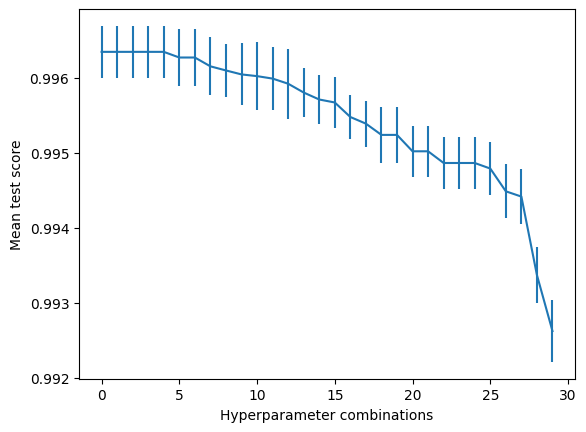

In [ ]:
# we can order the different models based on their performance
results_knn.sort_values(by='mean_test_score', ascending=False, inplace=True)

results_knn.reset_index(drop=True, inplace=True)

# plot model performance and error

results_knn['mean_test_score'].plot(yerr=[results_knn['std_test_score'], results_knn['std_test_score']], subplots=True)

plt.ylabel('Mean test score')
plt.xlabel('Hyperparameter combinations')

In [ ]:
# predict the results
y_pred=search_knn.predict(X_test)

In [ ]:
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

0.9805282763291568
0.9953531598513011
0.9656260565761299
0.9802642869401065


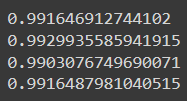

## Logistic Regression

In [ ]:
lr = LogisticRegression(solver = "saga")

Los hiperparámetros de LogisticRegression están dados en la [documentación](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) de scikit learn. Como solo se va a probar un hiperparámetro que tiene 3 valores pre-definidos, podemos usar GridSearch

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
clf_3 =  cross_validate(
    lr,
    X_train, 
    y_train,
    scoring='recall',
    return_train_score=True,
    cv=skf,
)

In [ ]:
print(clf_3['train_score'].mean())
print(clf_3['test_score'].mean())

0.8859022999715739
0.8859461621801816


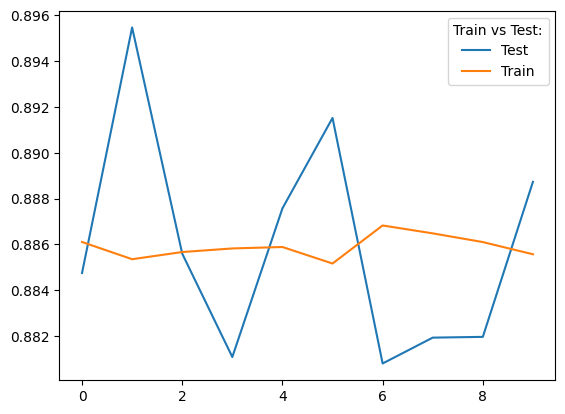

In [ ]:
plt.plot(range(10), clf_3['test_score'], label='Test')
plt.plot(range(10), clf_3['train_score'], label='Train')
plt.legend(title='Train vs Test:')
plt.show()

In [ ]:
lr.fit(X_train, y_train)

LogisticRegression(solver='saga')

In [ ]:
y_pred=lr.predict(X_test)

In [ ]:
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

0.8862174060277683
0.8853546139148027
0.8877493519666404
0.886550365785031


In [ ]:
param_grid_lr = {
    'penalty': ['l1', 'l2', 'elasticnet'], # default = 'l2'
}

Ahora optimizando con hiperparámetros

In [ ]:
# set up the search
search_lr = GridSearchCV(estimator=lr,
                          param_grid=param_grid_lr,
                          scoring='roc_auc',
                          n_jobs=-1, # Cuando colocamos menos 1 quiere decir que usaremos todos los cores disponibles en nuestra maquina
                          verbose = True,
                          cv=4,
                          refit=True, 
                          return_train_score=True)

In [ ]:
search_lr.fit(X_train, y_train)

Fitting 4 folds for each of 3 candidates, totalling 12 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
4 fits failed out of a total of 12.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1291, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose, prefer=prefer)(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/parallel.py", line 63, in __call__
    return super().__call__(iterab

GridSearchCV(cv=4, estimator=LogisticRegression(solver='saga'), n_jobs=-1,
             param_grid={'penalty': ['l1', 'l2', 'elasticnet']},
             return_train_score=True, scoring='roc_auc', verbose=True)

In [ ]:
search_lr.best_params_

{'penalty': 'l2'}

In [ ]:
search_lr.best_score_

0.9545688236323085

In [ ]:
# we also find the data for all models evaluated

results_lr = pd.DataFrame(search_lr.cv_results_)

print(results_lr.shape)

results_lr.head(5)

(3, 19)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,0.602381,0.062917,0.010486,0.000403,l1,{'penalty': 'l1'},0.955742,0.954503,0.952492,0.955536,0.954568,0.001287,2,0.954177,0.954669,0.955292,0.954269,0.954602,0.000439
1,0.494720,0.035793,0.009206,0.000832,l2,{'penalty': 'l2'},0.955743,0.954507,0.952488,0.955537,0.954569,0.001289,1,0.954178,0.954669,0.955292,0.954269,0.954602,0.000439
2,0.009837,0.000183,0.000000,0.000000,elasticnet,{'penalty': 'elasticnet'},NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
results_knn['std_test_score']

0     0.000346
1     0.000346
2     0.000346
3     0.000346
4     0.000346
5     0.000382
6     0.000382
7     0.000386
8     0.000359
9     0.000414
10    0.000453
11    0.000418
12    0.000465
13    0.000325
14    0.000331
15    0.000339
16    0.000296
17    0.000307
18    0.000378
19    0.000378
20    0.000343
21    0.000343
22    0.000343
23    0.000343
24    0.000343
25    0.000355
26    0.000362
27    0.000372
28    0.000370
29    0.000411
Name: std_test_score, dtype: float64

In [ ]:
# # we can order the different models based on their performance
# results_lr.sort_values(by='mean_test_score', ascending=False, inplace=True)

# results_lr.reset_index(drop=True, inplace=True)

# # plot model performance and error

# results_lr['mean_test_score'].plot(yerr=[results_knn['std_test_score'], results_knn['std_test_score']], subplots=True)

# plt.ylabel('Mean test score')
# plt.xlabel('Hyperparameter combinations')

In [ ]:
# predict the results
y_pred=search_lr.predict(X_test)

In [ ]:
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

0.8863867253640366
0.88556654676259
0.8878620534204891
0.8867128144521357


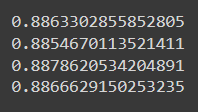